<a href="https://colab.research.google.com/github/Zakedu/workbook/blob/main/person_view_picture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [3]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf


In [4]:
import os
img_path = "/content/image.jpg"
img_orig = cv2.imread(img_path)
print (img_orig.shape)


(353, 403, 3)


In [13]:
class DeepLabModel(object):
   INPUT_TENSOR_NAME = 'ImageTensor:0'
   OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
   INPUT_SIZE = 513
   FROZEN_GRAPH_NAME = 'frozen_inference_graph'

   # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를
   # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다.
   def __init__(self, tarball_path):
       self.graph = tf.Graph()
       graph_def = None
       tar_file = tarfile.open(tarball_path)
       for tar_info in tar_file.getmembers():
           if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
               file_handle = tar_file.extractfile(tar_info)
               graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
               break
       tar_file.close()
       with self.graph.as_default():
           tf.compat.v1.import_graph_def(graph_def, name='')
           self.sess = tf.compat.v1.Session(graph=self.graph)

# 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
   def preprocess(self, img_orig):
       height, width = img_orig.shape[:2]
       resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
       target_size = (int(resize_ratio * width), int(resize_ratio * height))
       resized_image = cv2.resize(img_orig, target_size)
       resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
       img_input = resized_rgb
       return img_input
       
   def run(self, image):
       img_input = self.preprocess(image)
       
# Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
       batch_seg_map = self.sess.run(
           self.OUTPUT_TENSOR_NAME,
           feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

       seg_map = batch_seg_map[0]
       return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    


In [14]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)
print ('temp directory:', model_dir)
download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
   urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                  download_path)
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')


temp directory: /root/aiffel/human_segmentation/models
model loaded successfully!


In [15]:
#image resizing + segmentation 

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())


(353, 403, 3) (449, 513, 3) 15


In [16]:
#분류가능한 레이블
#그 중 15번 사람 분류
LABEL_NAMES = [
   'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
   'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
   'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)


21

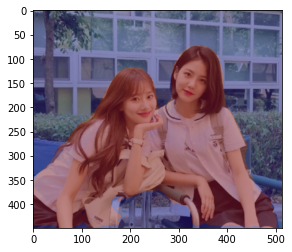

In [17]:
#사람을 제외하고 나머지는 0으로

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


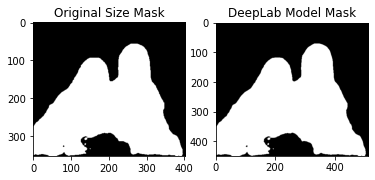

In [18]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


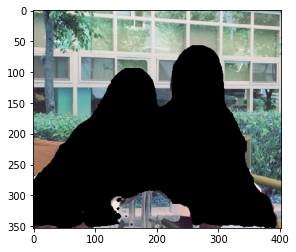

In [19]:
#배경만 추출해내기

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

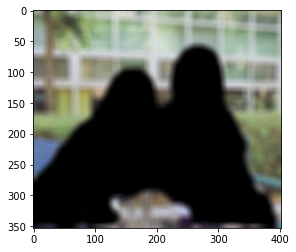

In [20]:
#배경 이미지 블러처리하기
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

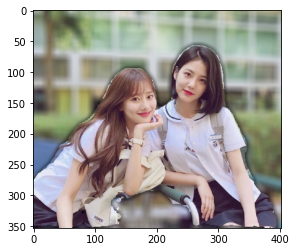

In [21]:
#기존 사진과 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


#**어색하고 개선이 필요한 곳**
 인물 사이의 의자 받침이 어색해서 공중에 부양한 것처럼 보임. 
 
 이나은이 들고 있는 가방이 형체를 잃어버림.
 
 두 인물 모두 누끼가 제대로 형성되지 않음.


(4600, 3234, 3)
(4600, 3234, 3) (513, 360, 3) 17


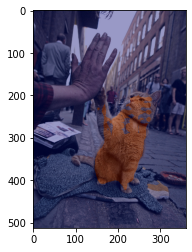

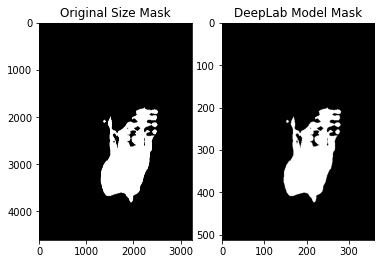

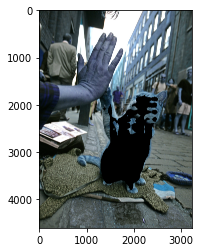

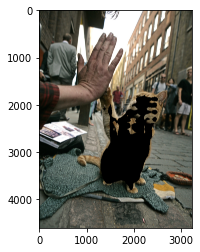

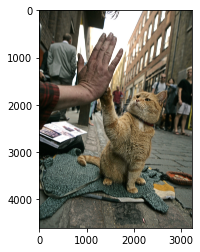

In [34]:
import os
img_path = "/content/cat.jpg"
img_orig = cv2.imread(img_path)
print (img_orig.shape)

#image resizing + segmentation 

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#사람을 제외하고 나머지는 0으로

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 cat 추출
img_mask = seg_map * (255/seg_map.max()) # 255 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#배경만 추출해내기

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#배경 이미지 블러처리하기
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


#기존 사진과 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


고양이 인식에는 성공하지만, 고양이보다 앞에 있는 사람의 손을 제대로 분류해내지 못하고 손과 비슷한 색깔인 고양이 몸통 부분 일부를 에러로 구분함.

(353, 403, 3)
(353, 403, 3) (449, 513, 3) 15


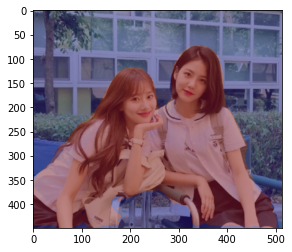

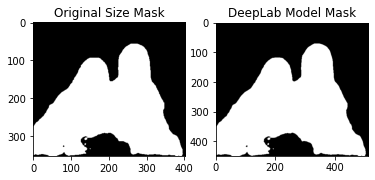

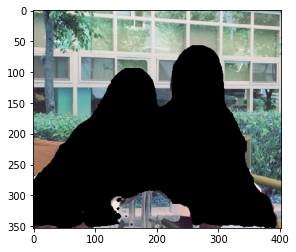

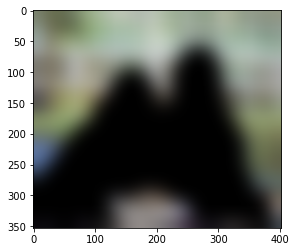

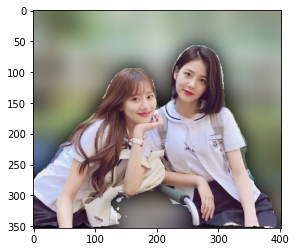

In [37]:
import os
img_path = "/content/image.jpg"
img_orig = cv2.imread(img_path)
print (img_orig.shape)

#image resizing + segmentation 

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#사람을 제외하고 나머지는 0으로

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람추출
img_mask = seg_map * (255/seg_map.max()) # 255 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#배경만 추출해내기

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

#배경 이미지 블러처리하기
img_bg_blur = cv2.GaussianBlur(img_bg, (99,99),0)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#기존 사진과 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


이를 극복해보기 위해 첫번째로 블러의 다른 함수를 가져와 봤지만 실패..


#여기서부터는 이미지 블러처리+엣지 찾기+사진 합치기를 위한 각고의 노력들...

In [40]:
# 이미지 불러오기
img = cv2.imread("/content/image.jpg")

# 변환 graky
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 임계값 조절
mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# mask
mask = 255 - mask

# morphology 적용
# borderconstant 사용
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask
# blur alpha channel
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# linear stretch so that 127.5 goes to 0, but 255 stays 255
mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# put mask into alpha channel
result = img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask

# 저장
cv2.imwrite('translated.png', result)

plt.show()